In [1]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'german'
seed = 1
np.random.seed(seed)

C:\Users\Eli\Anaconda3\envs\tf1\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
def get_scaler(preprocessor):
    scaler = preprocessor.transformers_[0][1].named_steps['scaler']
    return scaler

In [3]:
credit = np.genfromtxt('data/german/german.data-numeric')
categorical_features=[]

In [4]:
X, y = credit[:,:-1], credit[:,-1:].squeeze()

In [5]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


Epoch 1, Loss G: 0.534306953822224, loss_bb: 0.534306953822224
Epoch 2, Loss G: 0.48449235575269933, loss_bb: 0.48449235575269933
Epoch 3, Loss G: 0.501778668820056, loss_bb: 0.501778668820056
Epoch 4, Loss G: 0.4894670649001799, loss_bb: 0.4894670649001799
Epoch 5, Loss G: 0.45407125895171424, loss_bb: 0.45407125895171424
Epoch 6, Loss G: 0.5160971852246702, loss_bb: 0.5160971852246702
Epoch 7, Loss G: 0.48635165254555923, loss_bb: 0.48635165254555923
Epoch 8, Loss G: 0.4932478078898738, loss_bb: 0.4932478078898738
Epoch 9, Loss G: 0.4907660472207208, loss_bb: 0.4907660472207208
Epoch 10, Loss G: 0.49641561450511257, loss_bb: 0.49641561450511257
Epoch 11, Loss G: 0.48288802356986193, loss_bb: 0.48288802356986193
Epoch 12, Loss G: 0.47785784055924657, loss_bb: 0.47785784055924657
Epoch 13, Loss G: 0.5214356655554738, loss_bb: 0.5214356655554738
Epoch 14, Loss G: 0.5131001790117297, loss_bb: 0.5131001790117297
Epoch 15, Loss G: 0.4778452772801687, loss_bb: 0.4778452772801687
Epoch 16, L

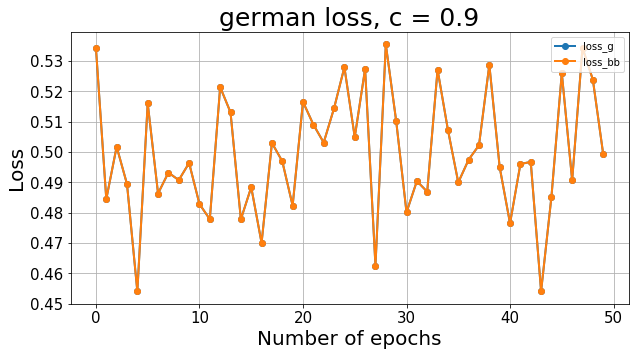

In [6]:
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
confidence_level = 0.9
gen_lr = 2e-5
loss = 'log'

rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss
                            )

hist = rf_ctgan.fit(train_data=z,
                    epochs=epochs,
                    confidence_level=confidence_level,
                    gen_lr=gen_lr,
                    )

# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")

plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
print()

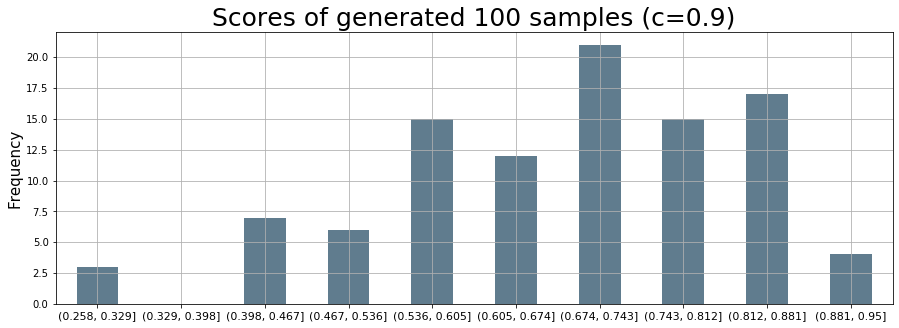

In [7]:
# check confidence for the generated samples
samples = 100
confidence_levels = [confidence_level]

for c in confidence_levels:
#     rf_ctgan = CTGANSynthesizer.load(f"{MODELS_PATH}/ctgan_c_{c}.pkl")
    gen_data = rf_ctgan.sample(samples)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores

    counts = pd.value_counts(y_conf_gen, bins=10, sort=False)
    plt.figure()
    ax = counts.plot.bar(rot=0, grid=True, color='#607c8e', figsize=(15,5))
    ax.set_xticklabels([str(interval) for interval in counts.index], fontsize=11)
    ax.set_ylabel('Frequency', fontsize=15)

    ax.set_title(f'Scores of generated {samples} samples (c={c})', fontsize=25)

In [8]:
# find samples s such that s.confidence > c
indecies = np.argwhere(y_conf_gen>confidence_level).squeeze()
print(f"indecies:\n\t{indecies}\nconfidence levels:\n\t{y_conf_gen[indecies]}")
indecies = indecies if indecies.shape != () else [indecies] # avoide no shape arrays

indecies:
	[59 82 94]
confidence levels:
	[0.94 0.95 0.91]


In [9]:
# inverse the generated data
scaler = get_scaler(preprocessor)
gen_data_above_c_before = gen_data.iloc[indecies]
gen_data_above_c = pd.DataFrame(scaler.inverse_transform(gen_data_above_c_before))

In [10]:
euclidean_scores, cosine_scores = calc_scores(gen_data_above_c, X_train)
print(f"euclidean_scores:\n\t{euclidean_scores}")
print(f"cosine_scores:\n\t{cosine_scores}")

euclidean_scores:
	{0: 30.56465856704921, 1: 39.54243784021406, 2: 40.0982406456121}
cosine_scores:
	{0: 0.9351884733448484, 1: 0.8379910478789299, 2: 0.7419638846050696}
